## Basic Setup

In [7]:
!pip install torchsummary

In [8]:
import pandas as pd
from collections import OrderedDict
import pydicom
import os
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image
import matplotlib.animation as animation
from IPython.display import HTML
import dotenv
import torch
import torchvision as tv
from torchvision.transforms import v2
import torchvision.models as models
from torch.nn.functional import silu, sigmoid, softmax
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torchsummary import summary
from sklearn.model_selection import train_test_split
import copy
import gc

from PIL import Image

# the data root for kaggle submission
root = '/kaggle/input/rsna-2023-abdominal-trauma-detection'
train_image_root = f'{root}/train_images'
train_data_path = f'{root}/train.csv'
scan_path = f'{root}/train_series_meta.csv'
injuries_path = f'{root}/image_level_labels.csv'
tag_path = f'{root}/train_dicom_tags.parquet'

## Data Reading

In [29]:
class Config:
    TRAIN_SPLIT = 0.8
    BATCH_SIZE = 20
    BATCH_PER_STEP = 3
    IMAGE_SIZE = 224
    NUM_EPOCHS = 10
    VAL_BATCH_SIZE=40
    NUM_LAYERS = 30
    BATCHES_PER_EVALUATION = 4
    
class Fields:
    BOWEL_INJURY = "bowel_injury"
    EXTRAVASATION_INJURY = "extravasation_injury"
    KIDNEY_HEALTHY = "kidney_healthy"
    KIDNEY_LOW = "kidney_low"
    KIDNEY_HIGH = "kidney_high"
    LIVER_HEALTHY = "liver_healthy"
    LIVER_LOW = "liver_low"
    LIVER_HIGH = "liver_high"
    SPLEEN_HEALTHY = "spleen_healthy"
    SPLEEN_LOW = "spleen_low"
    SPLEEN_HIGH = "spleen_high"
    LABELS = [
        "bowel_injury", "extravasation_injury",
        "kidney_healthy", "kidney_low", "kidney_high",
        "liver_healthy", "liver_low", "liver_high",
        "spleen_healthy", "spleen_low", "spleen_high",
    ]
torch.cuda.empty_cache()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
config = Config()
fields = Fields()

labels = pd.read_csv(train_data_path)
scans = pd.read_csv(scan_path)
injuries = pd.read_csv(injuries_path)
tags = pd.read_parquet(tag_path)

labels = labels.groupby('patient_id', as_index=True).first()
scans = scans.groupby('patient_id').max()

## Data Analysis

In [10]:
labels.sum()

bowel_healthy            3083
bowel_injury               64
extravasation_healthy    2947
extravasation_injury      200
kidney_healthy           2965
kidney_low                115
kidney_high                67
liver_healthy            2826
liver_low                 259
liver_high                 62
spleen_healthy           2793
spleen_low                199
spleen_high               155
any_injury                855
dtype: int64

In [11]:
labels.groupby(fields.LABELS).count().sort_values('any_injury', ascending=False)

bowel_healthy  \
bowel_injury extravasation_injury kidney_healthy kidney_low kidney_high liver_healthy liver_low liver_high spleen_healthy spleen_low spleen_high                  
0            0                    1              0          0           1             0         0          1              0          0                     2292   
                                                                        0             1         0          1              0          0                      178   
                                                                        1             0         0          0              1          0                      146   
             1                    1              0          0           1             0         0          1              0          0                       97   
             0                    1              0          0           1             0         0          0              0          1                       81   
                                  0              1          0           1             0         0          1              0          0                       64   
             1                    1              0          0           1             0         0          0              0          1                       31   
             0                    1              0          0           0             0         1          1              0          0                       31   
1            0                    1              0          0           1             0         0          1              0          0                       29   
0            0                    0              0          1           1             0         0          1              0          0                       18   
                                  1              0          0           0             1         0          0              1          0                       11   
1            1                    1              0          0           1             0         0          1              0          0                       11   
0            0                    0              1          0           0             1         0          1              0          0                       11   
                                                 0          1           0             1         0          1              0          0                       11   
                                                 1          0           1             0         0          0              0          1                        8   
             1                    1              0          0           0             1         0          1              0          0                        8   
                                                                                      0         1          1              0          0                        8   
             0                    1              0          0           0             1         0          0              0          1                        7   
                                  0              0          1           1             0         0          0              0          1                        7   
                                                 1          0           1             0         0          0              1          0                        6   
             1                    0              0          1           1             0         0          1              0          0                        6   
             0                    1              0          0           0             0         1          0              1          0                        6   
                                  0              1          0           0             0         1          1              0          0                        5   
             1                    1              0          0          

In [12]:
df = scans.loc[:,['series_id']]
df['imgroot'] = train_image_root + '/' + scans.index.astype(str) + '/' + scans['series_id'].astype(str)
df = df.apply(lambda x: pd.concat([x, labels.loc[x.name]]), axis=1)
df.iloc[:3]

,series_id,imgroot,bowel_healthy,bowel_injury,extravasation_healthy,extravasation_injury,kidney_healthy,kidney_low,kidney_high,liver_healthy,liver_low,liver_high,spleen_healthy,spleen_low,spleen_high,any_injury
patient_id,,,,,,,,,,,,,,,,
19,14374,/kaggle/input/rsna-2023-abdominal-trauma-detec...,1,0,1,0,1,0,0,1,0,0,1,0,0,0
26,41997,/kaggle/input/rsna-2023-abdominal-trauma-detec...,1,0,1,0,1,0,0,1,0,0,1,0,0,0
33,55570,/kaggle/input/rsna-2023-abdominal-trauma-detec...,0,1,0,1,1,0,0,0,1,0,1,0,0,1


In [13]:
train = pd.DataFrame()
val = pd.DataFrame()

for _, group in df.groupby(fields.LABELS):
    if len(group) == 1:
        train_split, val_split = (group, pd.DataFrame()) if np.random.rand() <= config.TRAIN_SPLIT else (pd.DataFrame(), group)
    else:
        train_split, val_split = train_test_split(group, train_size=config.TRAIN_SPLIT)
    train = pd.concat([train, train_split])
    val = pd.concat([val, val_split])

## Input Pipeline

In [14]:
image_augment = v2.Compose([
    v2.Resize(config.IMAGE_SIZE, antialias=True),
    v2.CenterCrop((config.IMAGE_SIZE, config.IMAGE_SIZE))
])

# utility functions
def read_image(path):
    ds = torch.from_numpy(pydicom.dcmread(path).pixel_array.astype('float32'))
    ds -= ds.min()
    ds /= ds.max()
    return image_augment(ds.unsqueeze(0))[0]

In [15]:
class MedicalDatabase(Dataset):
    def __init__(self, source: pd.DataFrame, num_elems: int, transfer_to_device):
        self.source = source
        self.els = num_elems
        self.transfer_to_device = transfer_to_device
    def __len__(self):
        return len(self.source)
    def __getitem__(self, idx):
        # 5-tuple of (is_bowel_injury, is_extravasation_injury, kidney (healthy/low/high), liver (healthy/low/high), spleen (healthy/low/high)
        src = self.source.iloc[idx]

        file_names = np.asarray(os.listdir(src['imgroot']))
        idx = np.round(np.linspace(0, len(file_names) - 1, self.els)).astype(int)
        files = [read_image(src['imgroot'] + '/' + x) for x in file_names[idx]]
        files = torch.stack(files)
        # (self.els, config.IMAGE_SIZE, config.IMAGE_SIZE)
        files = files.unsqueeze(1).expand((-1, 3, -1, -1))
        
        target = (src[fields.BOWEL_INJURY], src[fields.EXTRAVASATION_INJURY], 
                   src[[fields.KIDNEY_HEALTHY, fields.KIDNEY_LOW, fields.KIDNEY_HIGH]], 
                   src[[fields.LIVER_HEALTHY, fields.LIVER_LOW, fields.LIVER_HIGH]], 
                   src[[fields.SPLEEN_HEALTHY, fields.SPLEEN_LOW, fields.SPLEEN_HIGH]])
        target = tuple([np.asarray(x).astype('float32') for x in target])
        
        if self.transfer_to_device:
            target = tuple([torch.from_numpy(x).to(device) for x in target])
            files = files.to(device)
        return files, target
        

train_db = MedicalDatabase(train, config.NUM_LAYERS, False)
train_dl = DataLoader(MedicalDatabase(train, config.NUM_LAYERS, False), batch_size=config.BATCH_SIZE, num_workers=2, shuffle=True, pin_memory=True)
val_dl = DataLoader(MedicalDatabase(val, config.NUM_LAYERS, False), batch_size=config.VAL_BATCH_SIZE, num_workers=2, shuffle=False, pin_memory=True)

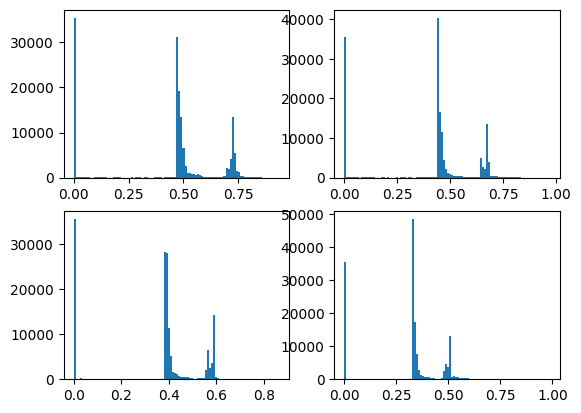

In [16]:
# see distribution of pixels
fig, ax = plt.subplots(2, 2)
ax[0][0].hist(train_db[0][0][0].flatten(), bins=100)
ax[0][1].hist(train_db[0][0][5].flatten(), bins=100)
ax[1][0].hist(train_db[0][0][10].flatten(), bins=100)
ax[1][1].hist(train_db[0][0][15].flatten(), bins=100)
plt.show()

In [17]:
# what's the shapes!
train_db[0][0].shape

torch.Size([30, 3, 224, 224])

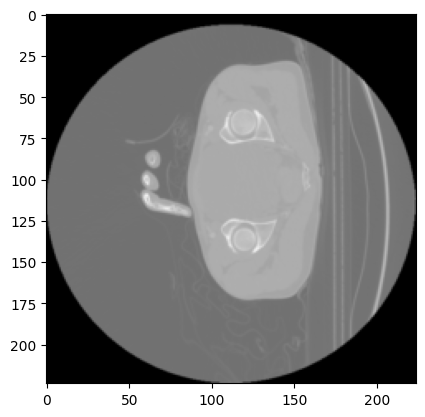

In [18]:
# view images
plt.imshow(np.swapaxes(train_db[0][0][4], 0, 2))

## Resnet50 Experimentation

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 284MB/s]
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed i

--2023-10-14 19:37:51--  https://github.com/BigWZhu/ResNet50/blob/master/Strawberry.jpg?raw=true
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/BigWZhu/ResNet50/raw/master/Strawberry.jpg [following]
--2023-10-14 19:37:51--  https://github.com/BigWZhu/ResNet50/raw/master/Strawberry.jpg
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/BigWZhu/ResNet50/master/Strawberry.jpg [following]
--2023-10-14 19:37:51--  https://raw.githubusercontent.com/BigWZhu/ResNet50/master/Strawberry.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK


<BarContainer object of 1000 artists>

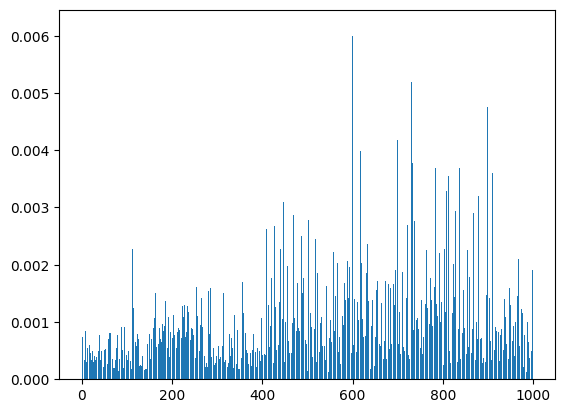

In [19]:
rn50 = models.resnet50(pretrained=True).to(device)
rn502 = models.resnet50(pretrained=False).to(device)

!wget https://github.com/BigWZhu/ResNet50/blob/master/Strawberry.jpg?raw=true

config.IMAGE_SIZE

tmp = np.expand_dims(np.moveaxis(np.array(Image.open('/kaggle/working/Strawberry.jpg?raw=true')), 2, 0).astype('float32'), 0)
tmp = torch.from_numpy(tmp).to(device)
tmp = v2.CenterCrop((config.IMAGE_SIZE, config.IMAGE_SIZE))(tmp)
tmp = v2.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])(tmp)
ans = rn50(tmp).detach()
ans = softmax(ans, dim=1)
ans = ans.cpu().numpy().flatten()
plt.bar(x=range(0, 1000), height=ans)
# tmp.shape

In [20]:
summary(rn50, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [21]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
    def forward(self, x):
        return x

rn50_back = copy.deepcopy(rn50)
rn50_back.fc = Identity()
summary(rn50_back, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [22]:
# see variance in full output for medical images
out = rn50(train_db[0][0].float().to(device)).detach().cpu().numpy()

np.std(out, axis=1), np.min(out, axis=1), np.max(out, axis=1)

(array([1.1934127 , 1.2571973 , 1.3565766 , 1.3006412 , 1.3999267 ,
        1.3086942 , 1.4929706 , 1.3674765 , 1.4158944 , 1.3696678 ,
        1.3788694 , 1.4221572 , 1.4562052 , 1.5580136 , 1.4152656 ,
        1.437326  , 1.2669376 , 1.3568174 , 1.4177868 , 1.4305485 ,
        1.0708447 , 0.98755175, 1.1946286 , 1.3779416 , 1.4132556 ,
        1.4740661 , 1.334386  , 1.2024049 , 1.124162  , 1.2255843 ],
       dtype=float32),
 array([-3.5983348, -3.952725 , -3.4071126, -4.1994715, -3.8278306,
        -3.6617315, -4.8934126, -4.2545643, -3.8364806, -3.6168504,
        -3.9690328, -4.003903 , -3.3398457, -4.2780695, -3.5428574,
        -4.2934155, -3.9158664, -3.8244202, -3.9410224, -4.1017528,
        -3.4681573, -2.7353492, -3.1555183, -4.0542994, -3.6482105,
        -4.900651 , -4.2004523, -3.0513375, -3.1458266, -3.775006 ],
       dtype=float32),
 array([4.071919 , 4.3947654, 4.8452344, 5.388489 , 4.9394627, 4.9660945,
        7.3111687, 4.580224 , 4.721422 , 4.875109 , 5.5055423,

In [23]:
# variance in partial output for medical images
out2 = rn50_back(train_db[0][0].float().to(device))

np.std(out2.detach().cpu().numpy(), axis=1), np.min(out2.detach().cpu().numpy(), axis=1), np.max(out2.detach().cpu().numpy(), axis=1)

(array([0.21385366, 0.27458802, 0.2277623 , 0.25467646, 0.23367807,
        0.25194097, 0.30528998, 0.24988092, 0.30344814, 0.24748382,
        0.2892986 , 0.28134534, 0.30333993, 0.27552384, 0.26682127,
        0.27186704, 0.26547784, 0.23299447, 0.27859342, 0.26509738,
        0.23174132, 0.20118673, 0.24673851, 0.28450027, 0.27037278,
        0.29045886, 0.22682515, 0.23707893, 0.22207691, 0.22604801],
       dtype=float32),
 array([0.0028531 , 0.00638731, 0.0216514 , 0.0021022 , 0.00347212,
        0.01789128, 0.00805885, 0.01527802, 0.01786879, 0.0025673 ,
        0.00531832, 0.01274105, 0.00881914, 0.0250577 , 0.        ,
        0.00151586, 0.01303705, 0.03442682, 0.01564733, 0.00316638,
        0.02192734, 0.03554995, 0.0082852 , 0.00949936, 0.02436606,
        0.01569017, 0.02016415, 0.01241411, 0.01037701, 0.01853919],
       dtype=float32),
 array([1.8037913, 1.800963 , 1.6305984, 1.5607219, 1.5668432, 1.6812813,
        2.1559389, 1.6643608, 2.1737342, 1.7269597, 1.9990715,

## Model Definition

In [24]:
network_preparer = v2.Compose([
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        
        # parameters to fine-tune
        self.tune_params = []
        
        backbone = models.resnet50(weights=models.ResNet50_Weights.DEFAULT, progress=True)
        for layer in list(backbone.children())[:7]:
            for param in layer.parameters():
                param.requires_grad = False
        for param in backbone.layer4[:2].parameters():
            param.requires_grad = False
        for layer in list(backbone.layer4[2].children())[:4]:
            for param in layer.parameters():
                param.requires_grad = False
        for layer in list(backbone.layer4[2].children())[4:]:
            for param in layer.parameters():
                param.requires_grad = True
                self.tune_params.append(param)

        backbone.fc = nn.Linear(2048, 100)
        self.backbone = backbone
        self.dense1 = nn.Linear(100, 100)
        self.necks = nn.ModuleList([nn.Linear(100, 32) for _ in range(5)])
        self.activate = nn.ModuleList([nn.Linear(32, 1), nn.Linear(32, 1), nn.Linear(32, 3), nn.Linear(32, 3), nn.Linear(32, 3)])
        
        self.init_params = []
        for i in [self.backbone.fc, self.dense1, self.necks, self.activate]:
            self.init_params += list(i.parameters())
        
    def forward(self, x): # batches x images x channels x width x height
        inp_shape = x.shape
        # run network on each image
        x = x.reshape(shape=(-1,*x.shape[2:]))
        x = network_preparer(x) # run some preprocessing
        x = x.clip(0, 1)
        x = self.backbone(x)
        x = silu(x)
        x = silu(self.dense1(x))
        
        # create necks and activate for each image
        x = [silu(i(x)) for i in self.necks]
        x = [silu(i(x[ind])) for ind, i in enumerate(self.activate)]
        
        # split images into batch and image - now it is ([batch x image x answer])
        x = [i.reshape(shape=(*inp_shape[:2], -1)) for ind, i in enumerate(x)]
        
        # calculate means
        x = [i.mean(axis=1) for i in x]
        x = [sigmoid(x[0]).squeeze(dim=1), sigmoid(x[1]).squeeze(dim=1), softmax(x[2], dim=1), softmax(x[3], dim=1), softmax(x[4], dim=1)]
        return tuple(x)

## Evaluation Protocol

In [25]:
def get_injury_pred(x):
    injury_pred = torch.stack((x[0], x[1], 1-x[2][:,0], 1-x[3][:,0], 1-x[4][:,0])).max(dim=0)
    return injury_pred[0]

def ans_to_array(x): # 5-tuple of [(batch), (batch), (batch, 3), (batch, 3), (batch, 3)]
    bin_arr = torch.stack([1-x[0], x[0], 1-x[1], x[1]])
    bin_arr = [i.reshape((-1, 1)) for i in bin_arr]
    any_injury = get_injury_pred(x).reshape((-1, 1))
    
    # [(batch, 1), (batch, 1), (batch, 3), (batch, 3), (batch, 3)]
    arr = torch.cat(bin_arr + [x[2], x[3], x[4], any_injury], dim=1)
    return arr

loss_cross = nn.BCELoss(weight=torch.from_numpy(np.array([1, 2, 1, 6, 1, 2, 4, 1, 2, 4, 1, 2, 4, 6])), reduction='none').to(device)

def loss_fn(x, targets):
    pred_sub = ans_to_array(x)
    target_sub = ans_to_array(targets)
    
    return loss_cross(pred_sub, target_sub).mean(dim=1)

In [26]:
# testing
x = (np.zeros((5,)), np.zeros((5,)), np.zeros((5,3)), np.zeros((5, 3)), np.zeros((5, 3)))
x[2][:,0] = 1
x[3][:,0] = 1
x[4][:,0] = 1
x = [torch.from_numpy(i).to(device) for i in x]
target = x
loss_fn(x, target)

tensor([0., 0., 0., 0., 0.], device='cuda:0', dtype=torch.float64)

## Training Protocol

In [30]:
history = pd.DataFrame(columns=['epoch', 'batch #', 'output', 'answer', 'loss', 'avgloss'])

torch.cuda.empty_cache()
gc.collect()
model = Classifier().to(device)

In [31]:
def to_device(data):
    sec = tuple([i.float().to(device) for i in data[1]])
    return data[0].float().to(device), sec

# train without convnet optimization
optimizer = torch.optim.Adam(model.init_params)
for epoch in range(config.NUM_EPOCHS):
    print(f'----------- Epoch {epoch} -------------')
    for batchnum, data in enumerate(train_dl):
        print(f'begin batch {batchnum}', end="; ")
        data = to_device(data)
        print("loaded gpu...", end="; ")
        y = model(data[0])
        ans = data[1]
        loss = loss_fn(y, ans)
        avgloss = loss.mean()
        history.loc[len(history)] = {
            'epoch': epoch,
            'batch #': batchnum,
            'output': y,
            'answer': [i.cpu().detach().numpy() for i in ans], 
            'loss': loss.cpu().detach().numpy(),
            'avgloss': avgloss.cpu().detach().numpy()
        }
        
        print("items calculated", end="; ")
        optimizer.zero_grad()
        avgloss.backward()
        optimizer.step()
        print("done batch")
        print(f'Epoch {epoch} batch {batchnum}: average loss {avgloss}')
    val_losses = np.array([])
    for data in val_dl:
        data = to_device(data)
        y = model(data[0])
        ans = data[1]
        batch_loss = loss_fn(y, ans)
        loss = loss.mean()
        val_losses = np.concatenate(val_losses, loss)
    history.loc[len(history)] = {
        'epoch': epoch,
        'batch #': 'validation',
        'output': 0,
        'answer': 0,
        'loss': val_losses,
        'avgloss': val_losses.mean()
    }
    print(f'Epoch {epoch} average loss: {avgloss}')

----------- Epoch 0 -------------
begin batch 0; loaded gpu...; 

OutOfMemoryError: CUDA out of memory. Tried to allocate 3.59 GiB (GPU 0; 15.90 GiB total capacity; 13.65 GiB already allocated; 43.75 MiB free; 14.96 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF